This notebook implements an implicit-feedback recommender based on the NCF (Neural Collaborative Filtering) architecture. The work includes the following steps:  
1. **Data preparation**: load the Movielens dataset, perform simple EDA, filter and split data into sets, binarize interactions and generate negatives.  
2. **Modeling**: train an NCF model with BCEWithLogitsLoss and early stopping.  
3. **Evaluation**: generate top‑K recommendations and compare the NCF model against a popularity baseline and ALS using Recall@20, Precision@20, and MRR@20.  

In [1]:
!pip install implicit --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 57.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam

from utils import (filter_items,
                   tr_tst_split,
                   negative_sampling,
                   count_parameters,
                   recall,
                   precision,
                   mrr)
from training_utils import EarlyStopping, train_model
from datasets import MovieLensDataset
from model import NCF
from sklearn.model_selection import train_test_split
from implicit.als import AlternatingLeastSquares

In [3]:
plt.rcParams['figure.dpi'] = 600

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

- simple EDA
- filtering rare items and users
- train-test split
- reindexing if necessary
- binarize labels for NCF task

In [5]:
DATA_PATH = '/content/drive/MyDrive/ML/projects/ncf/data'
ratings_file = os.path.join(DATA_PATH, 'ratings.dat')

In [6]:
df = pd.read_csv(ratings_file, sep='::', engine='python', names=['user', 'item', 'rating', 'timestamp'])

In [7]:
df.head()

,user,item,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
# Check for NaNs
df.isna().sum()

,0
user,0
item,0
rating,0
timestamp,0


In [9]:
# Check for duplicates
duplicates = df.duplicated(subset=['user', 'item'], keep=False)
num_duplicates = duplicates.sum()
print(f"Found {num_duplicates} duplicate user-item pairs")

Found 0 duplicate user-item pairs


In [10]:
print(f'Unique users: {df["user"].nunique()}')
print(f'Unique items: {df["item"].nunique()}')

Unique users: 6040
Unique items: 3706


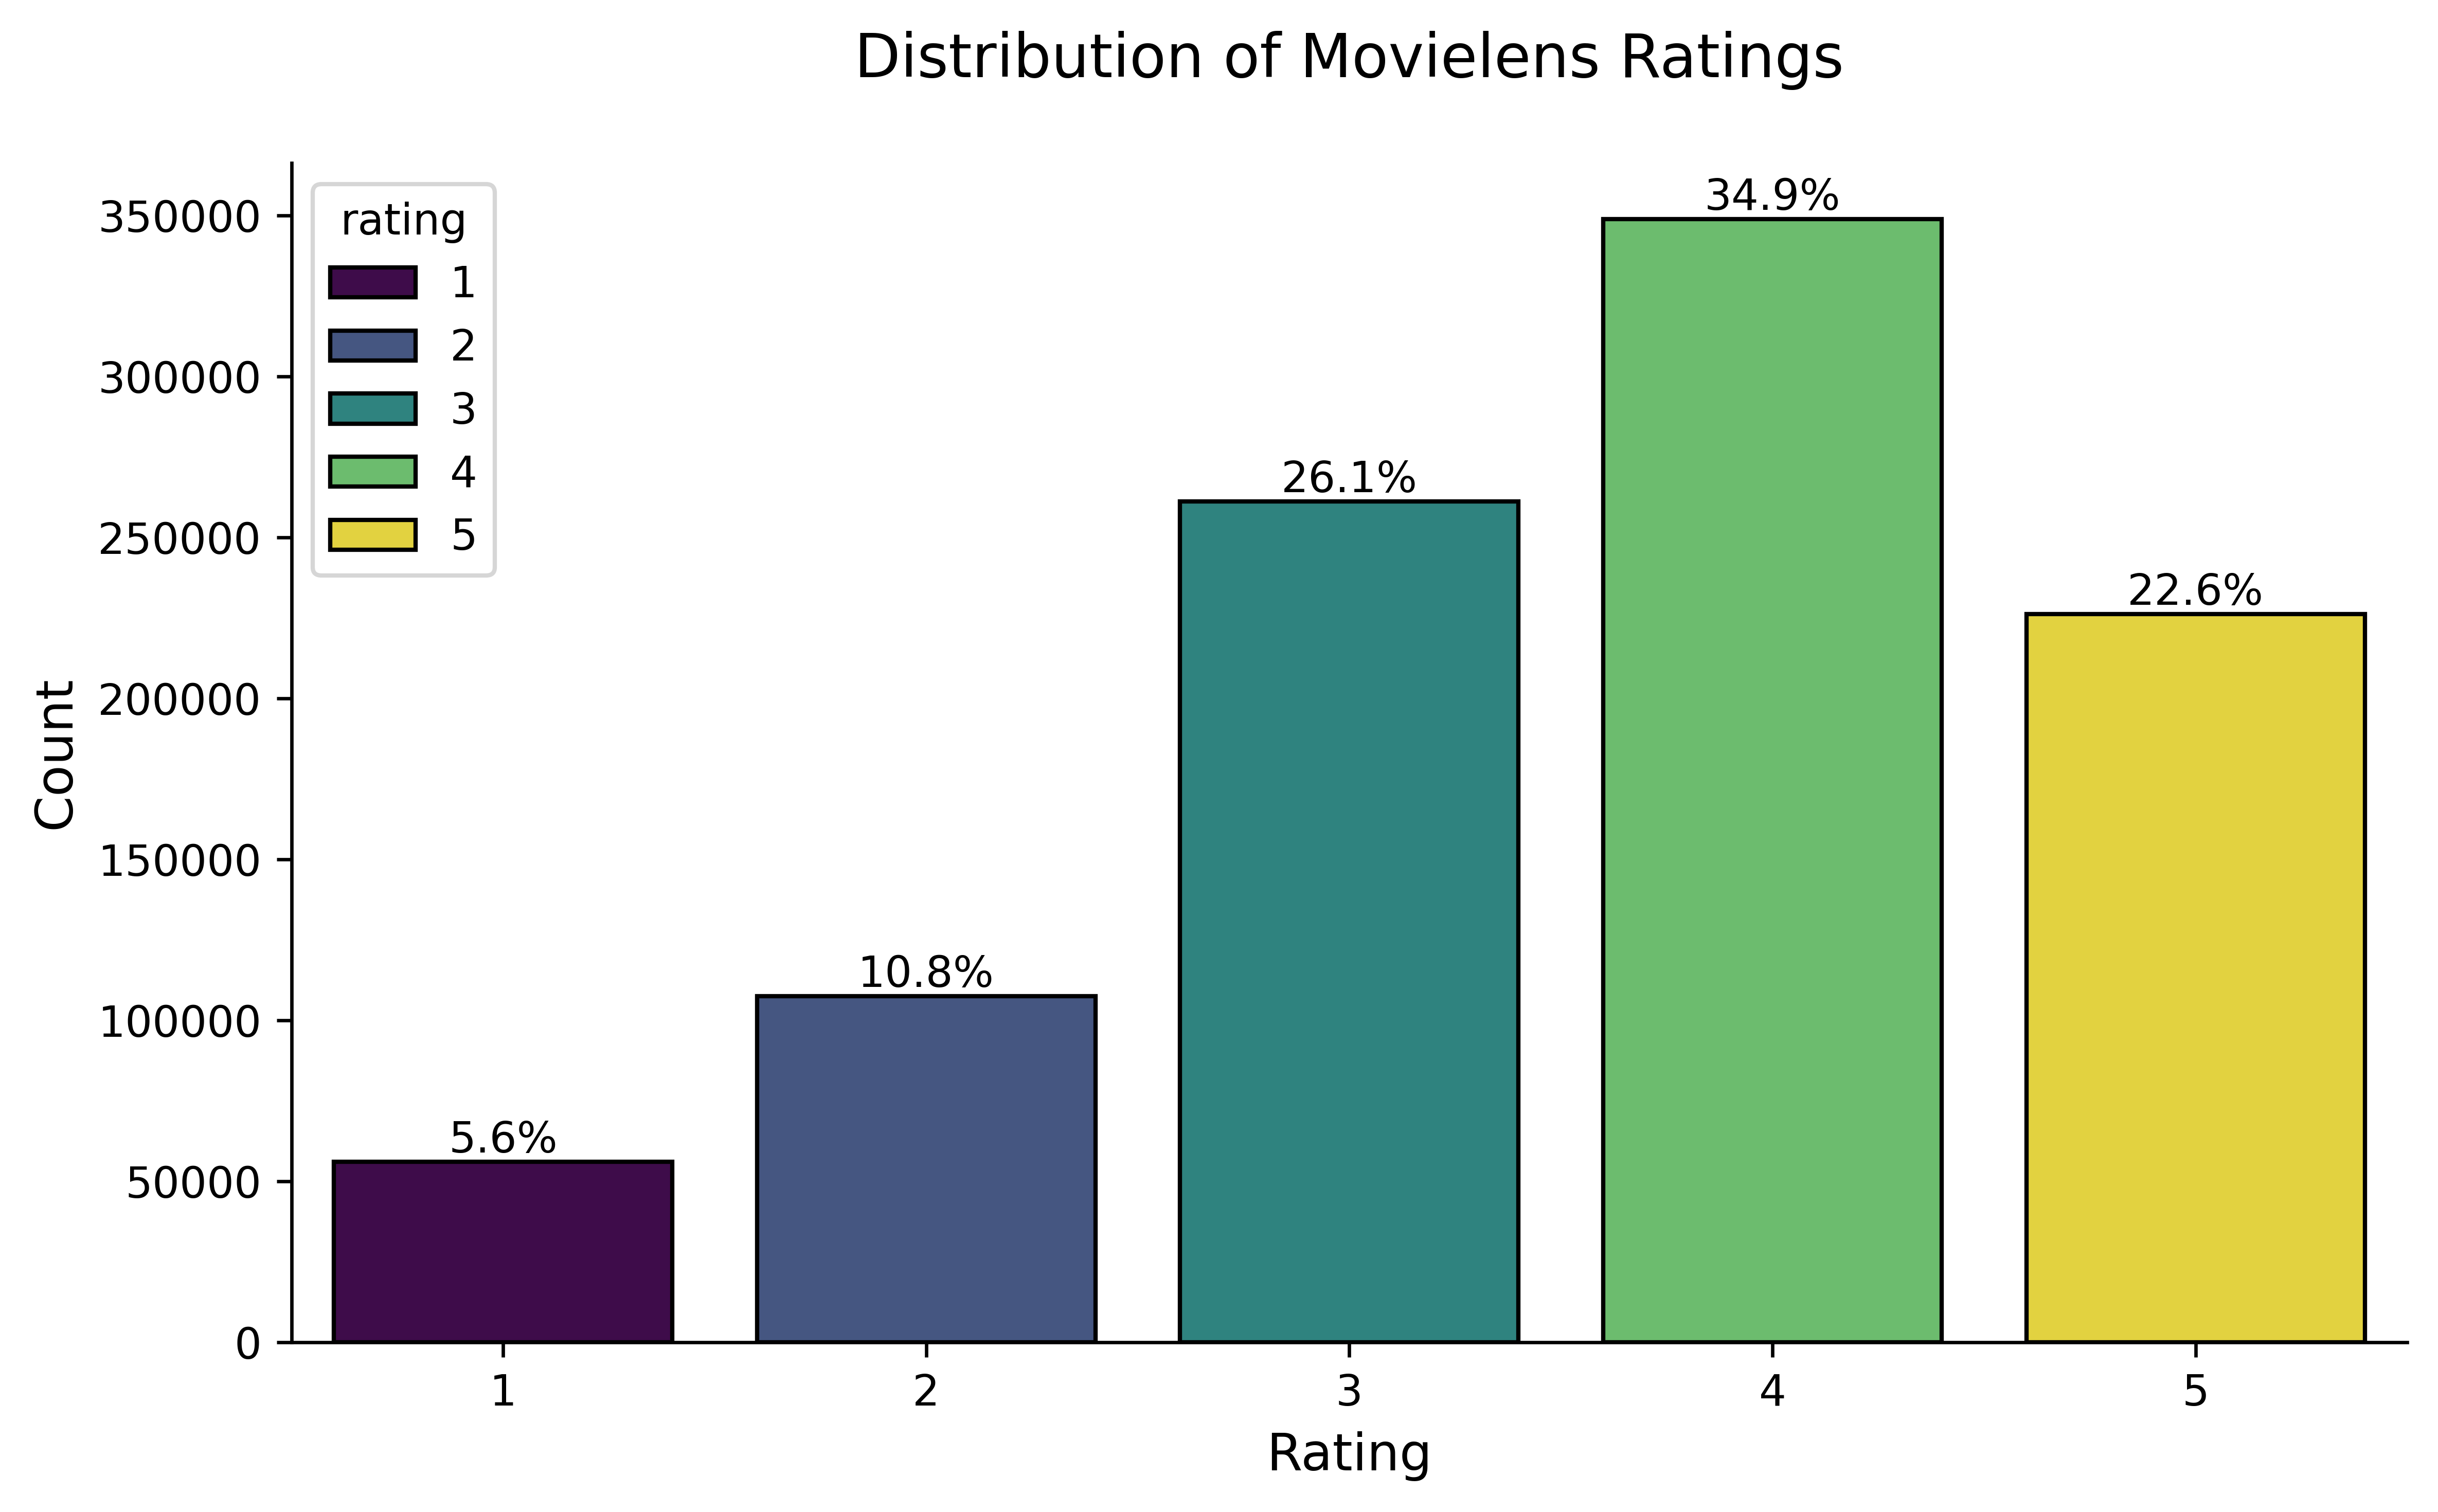

In [11]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x="rating", hue="rating",
                   palette="viridis",
                   edgecolor="black",
                   linewidth=1)

plt.title("Distribution of Movielens Ratings", fontsize=14, pad=20)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)

# plot percentage values above bars
total = len(df)
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue
    percentage = 100 * p.get_height()/total
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

sns.despine()
plt.tight_layout()
plt.show()

In [12]:
user_count = df.groupby('user')['item'].count()

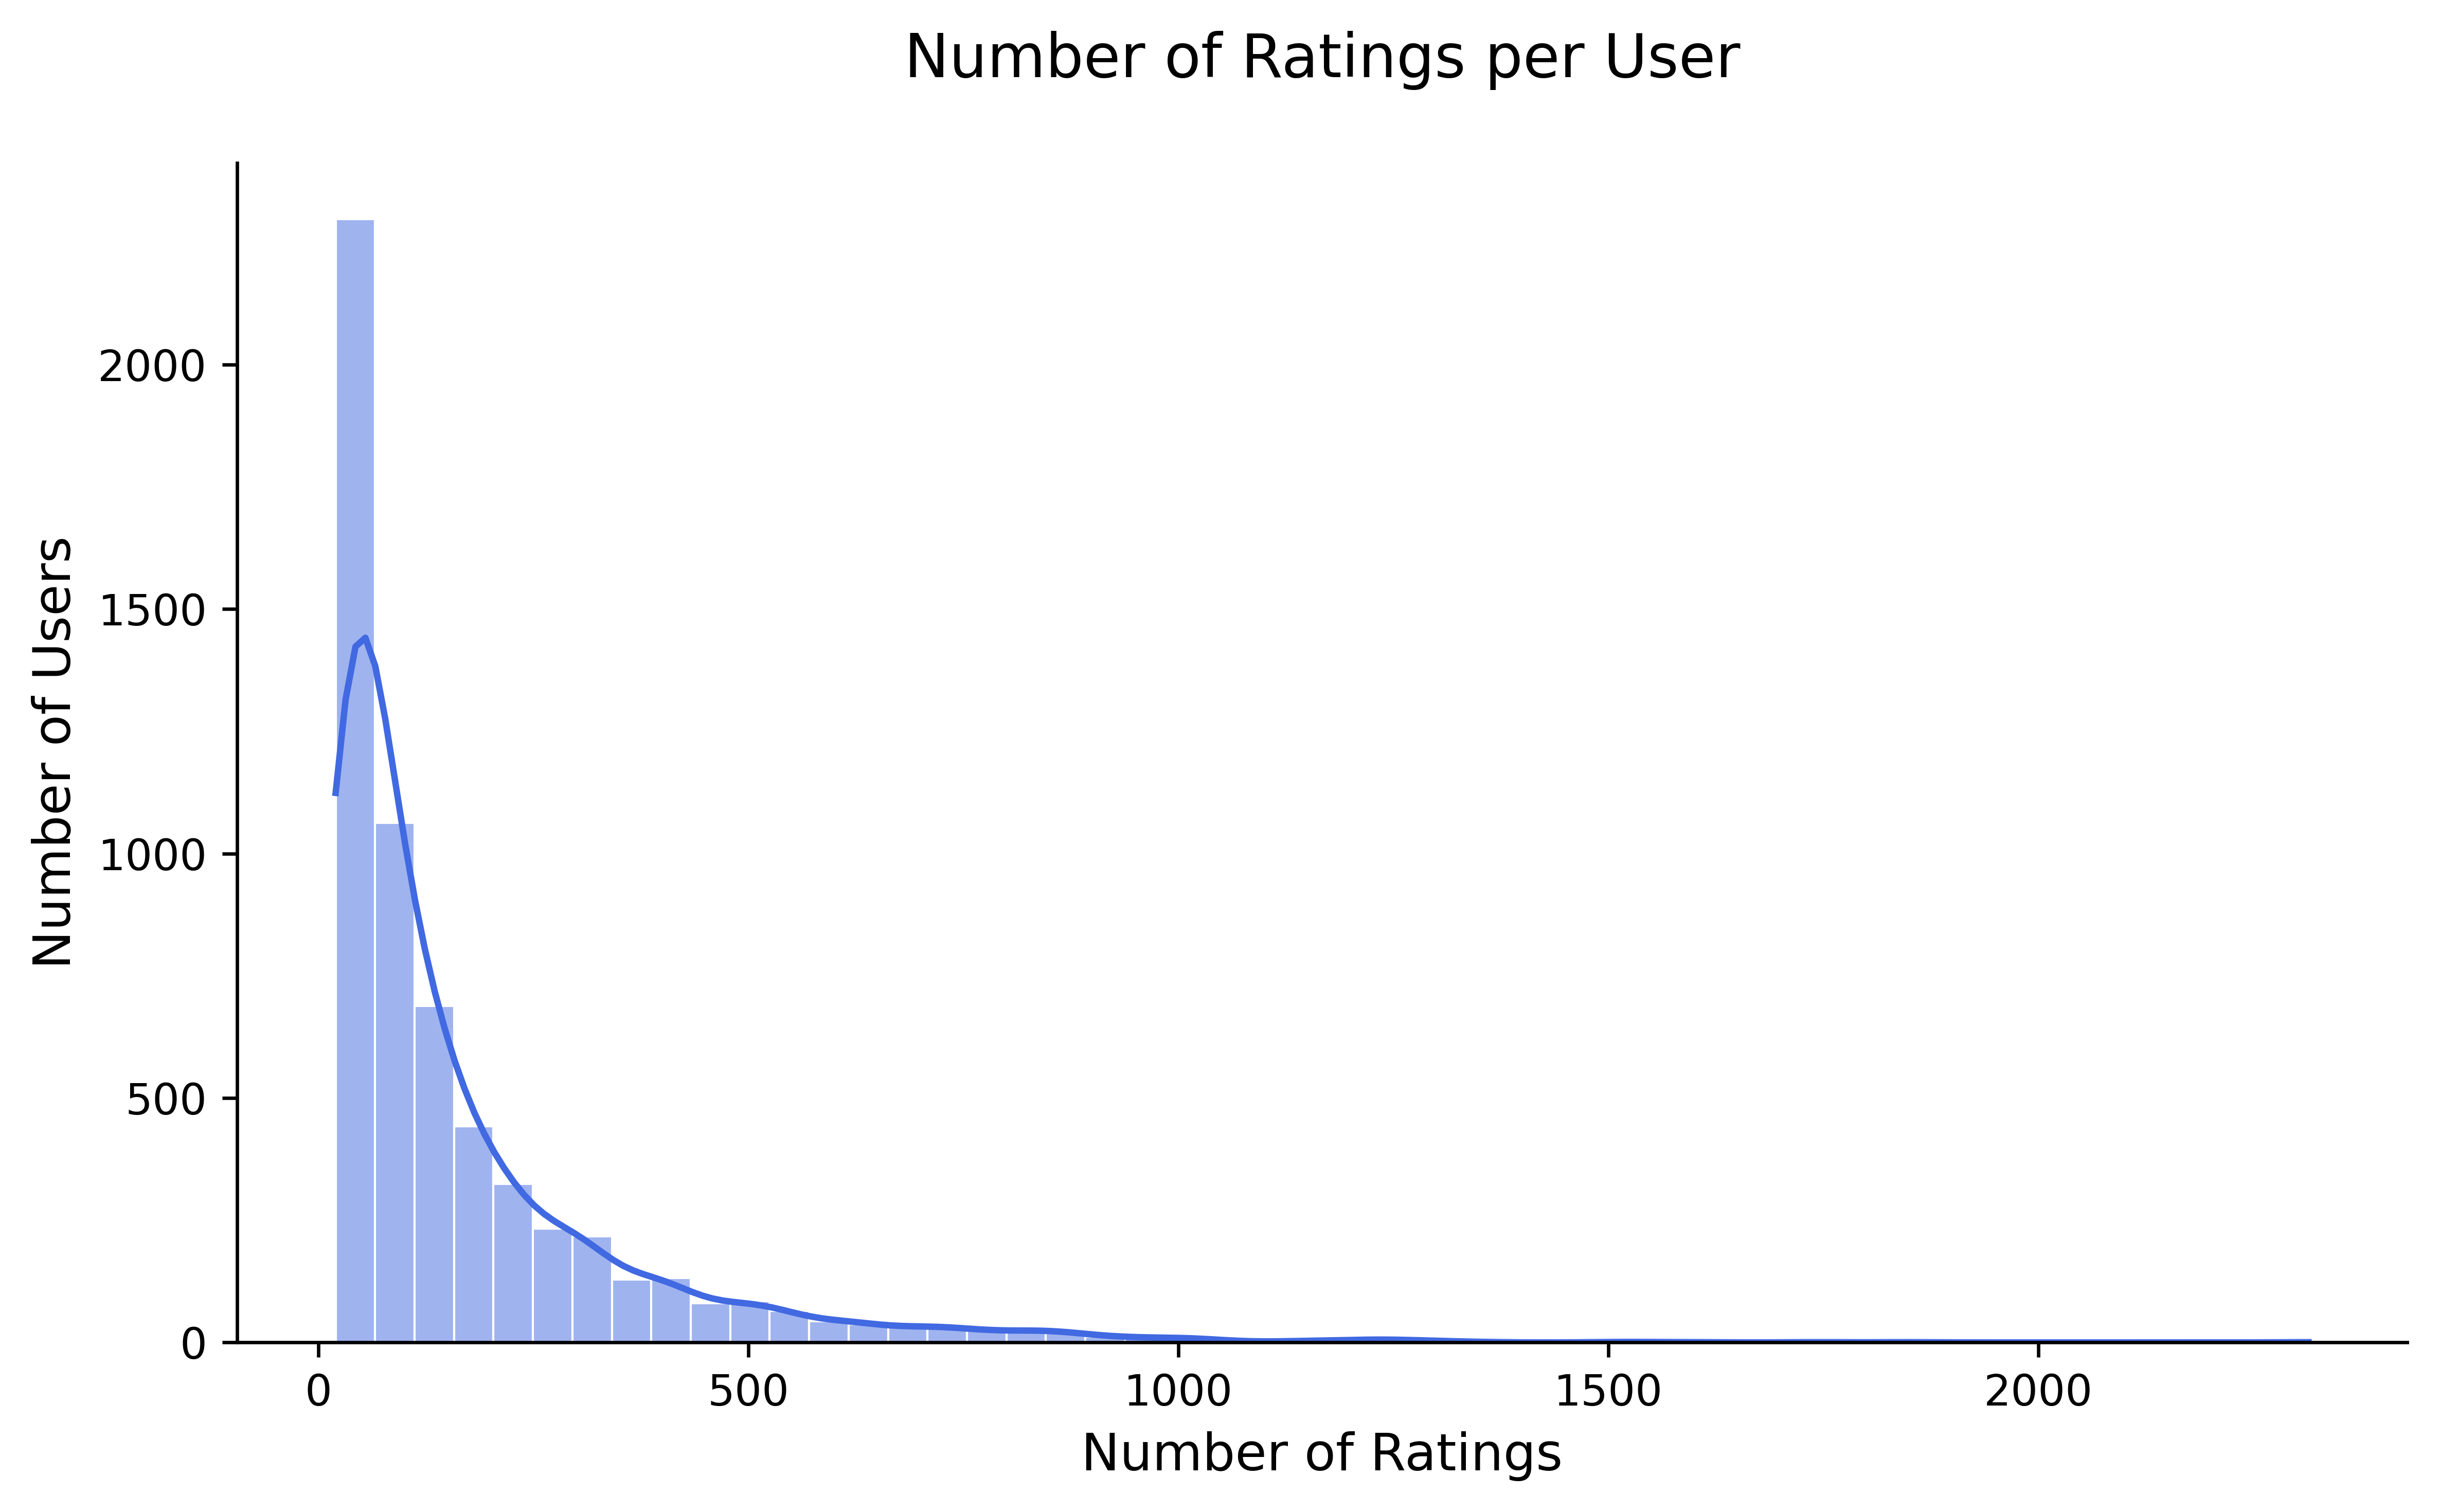

In [61]:
plt.figure(figsize=(8, 5))
ax = sns.histplot(user_count,
                 bins=50,
                 color='royalblue',
                 kde=True,
                 edgecolor='white',
                 linewidth=0.5)

plt.title('Number of Ratings per User', fontsize=14, pad=20)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [14]:
user_count.describe()

,item
count,6040.000000
mean,165.597517
std,192.747029
min,20.000000
25%,44.000000
50%,96.000000
75%,208.000000
max,2314.000000


In [15]:
item_count = df.groupby('item')['user'].count()

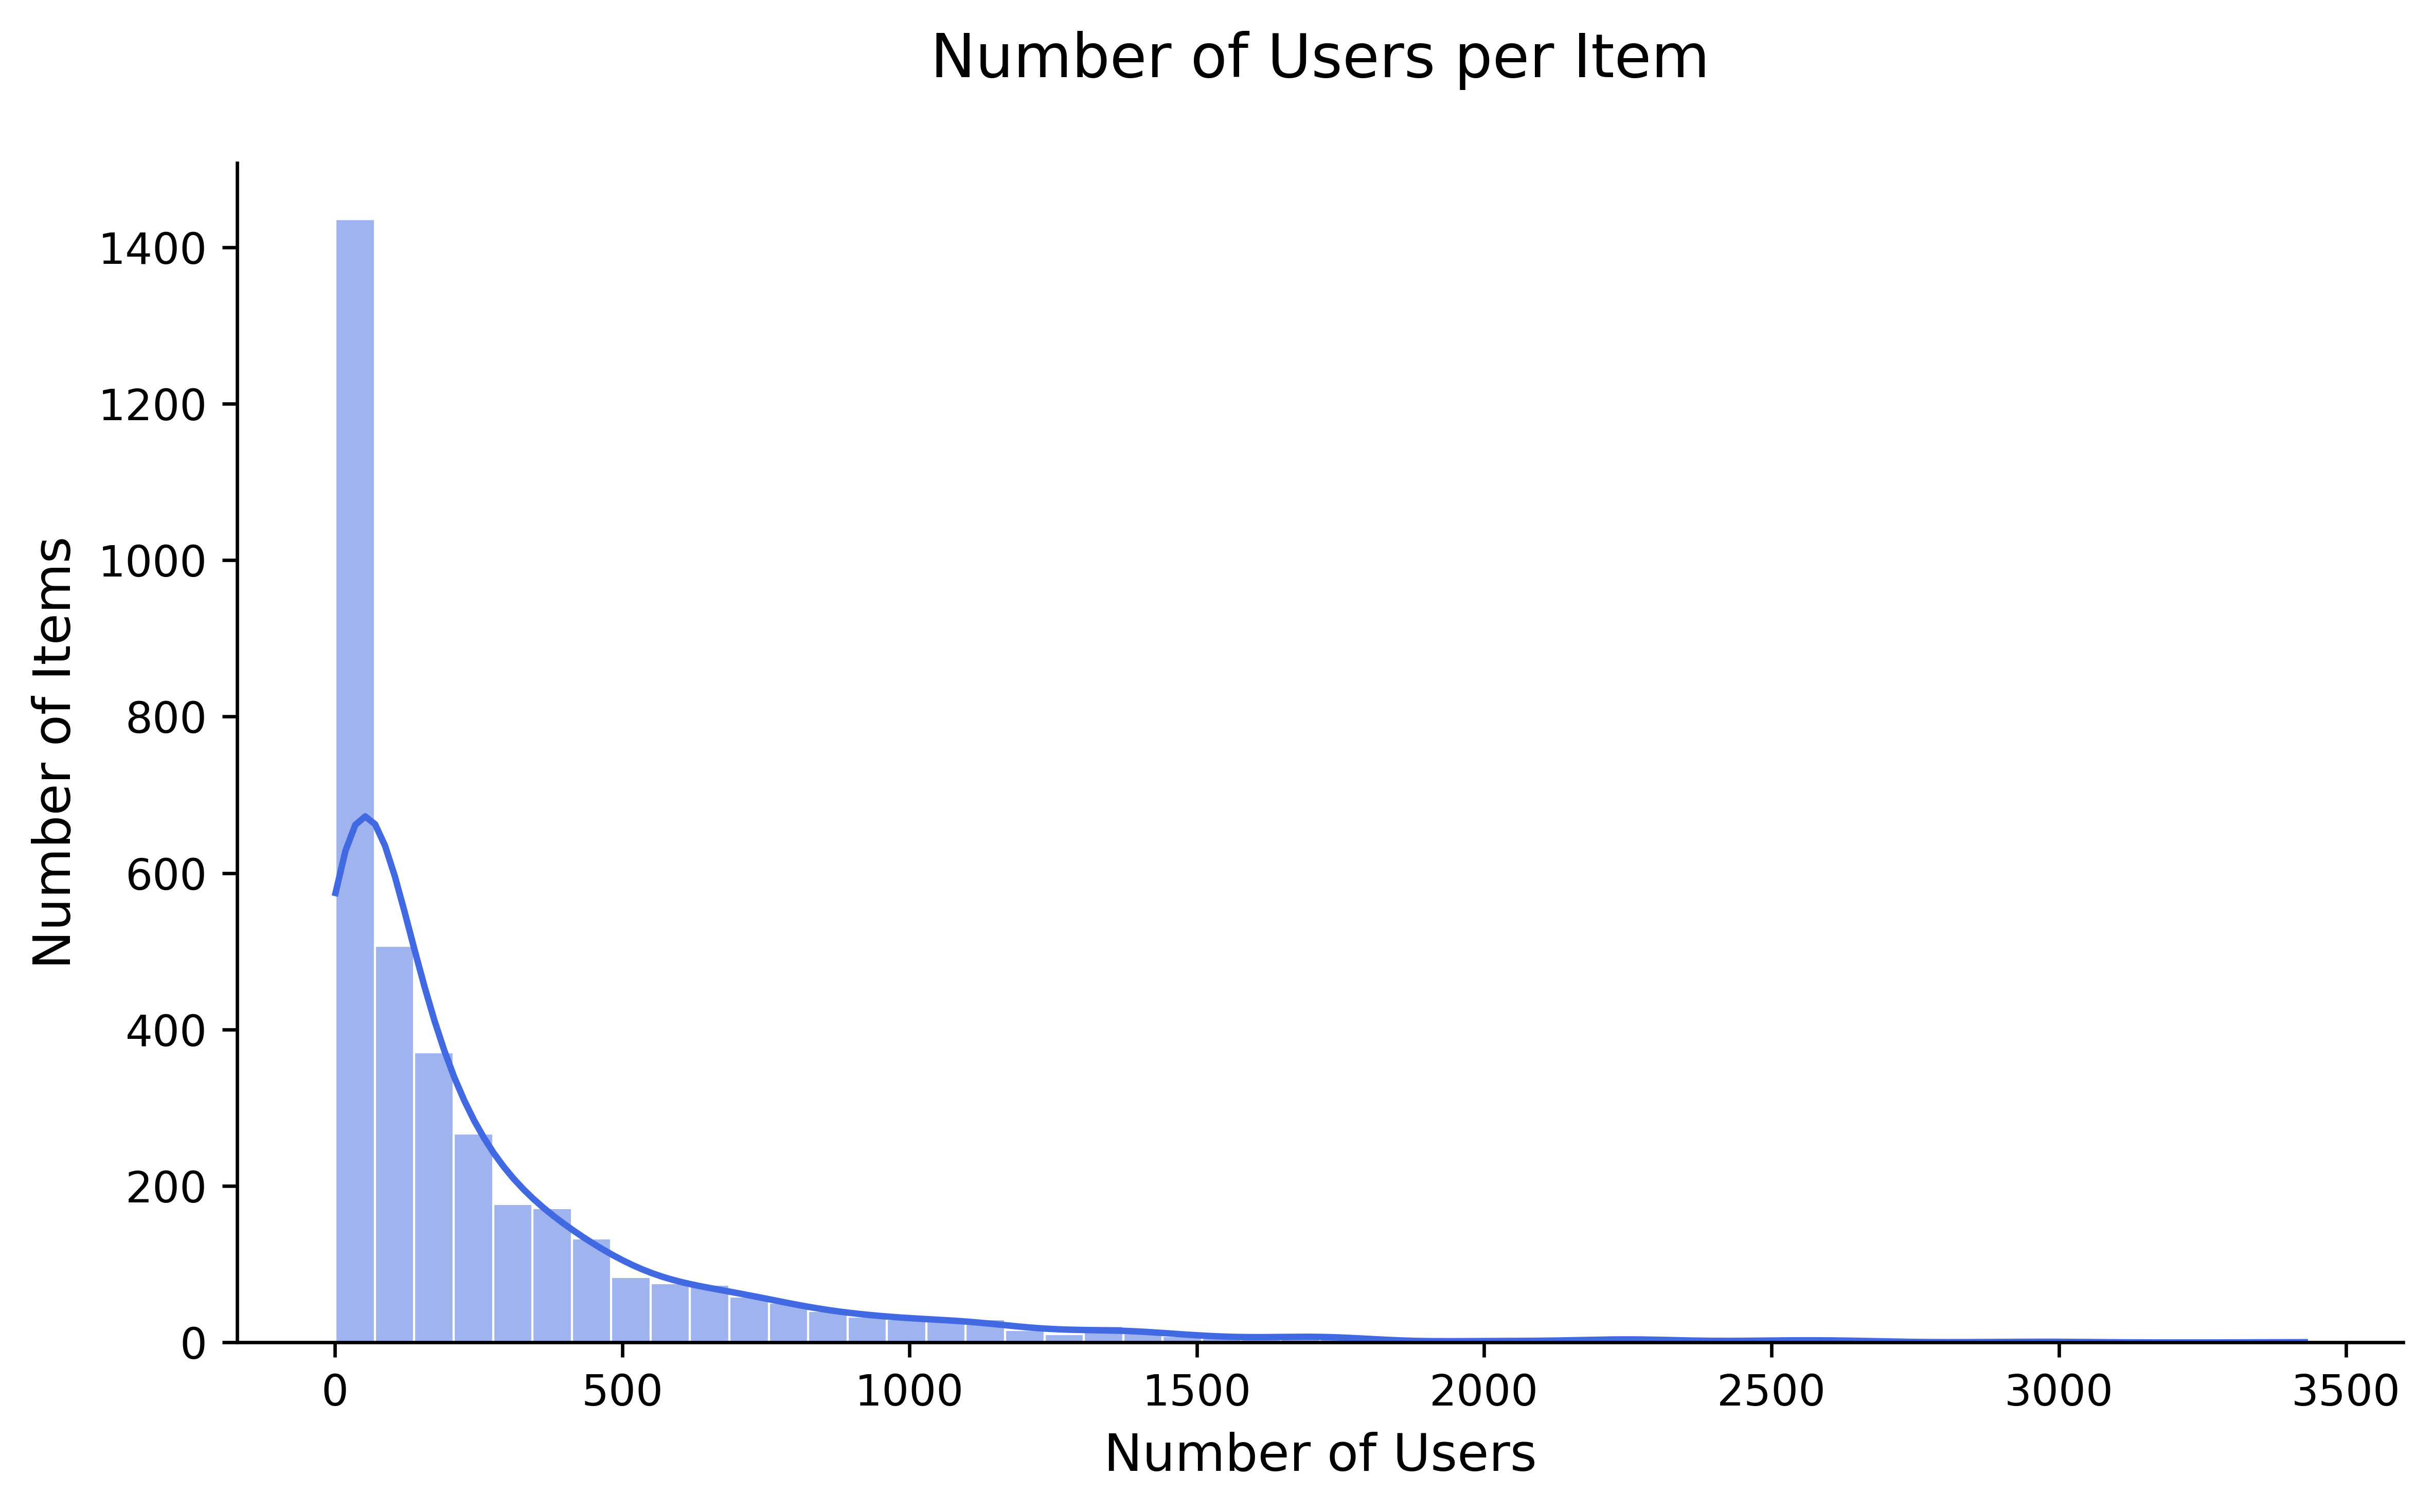

In [62]:
plt.figure(figsize=(8, 5))
ax = sns.histplot(item_count,
                 bins=50,
                 color='royalblue',
                 kde=True,
                 edgecolor='white',
                 linewidth=0.5)

plt.title('Number of Users per Item', fontsize=14, pad=20)
plt.xlabel('Number of Users', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [17]:
item_count.describe()

,user
count,3706.000000
mean,269.889099
std,384.047838
min,1.000000
25%,33.000000
50%,123.500000
75%,350.000000
max,3428.000000


Each user in our dataset has rated at least 20 movies. However, there are some items with very few ratings, and we will filter them out.

In [18]:
df = filter_items(df, 'user', 'item')

Filtering items..
Number of items before: 3706
Number of items after: 3043
Interactions length before: 1000209
Interactions length after: 995492
Does each user still have enough ratings?
Yes


In [19]:
train, test = tr_tst_split(df)

In [20]:
# sanity check
train['timestamp'].max() < test['timestamp'].min()

True

In [21]:
# another sanity check
len(test[~test['user'].isin(train['user'])])

0

In [22]:
# use a threshold to filter out movies that users didn't like in the test set
test = test[test['rating'] >= 4]
test.reset_index(inplace=True, drop=True)

In [23]:
print(f'Unique train users: {train["user"].nunique()}')
print(f'Unique test users: {test["user"].nunique()}')

Unique train users: 5399
Unique test users: 1120


Reassign user and item IDs

In [24]:
all_users = train["user"].unique().tolist()
all_items = train["item"].unique().tolist()

n_users = train["user"].nunique()
n_items = train["item"].nunique()

user_id2idx = dict(zip(all_users, range(n_users)))
item_id2idx = dict(zip(all_items, range(n_items)))

train["user"] = train["user"].map(user_id2idx)
train["item"] = train["item"].map(item_id2idx)
test["user"] = test["user"].map(user_id2idx)
test["item"] = test["item"].map(item_id2idx)

# Popularity-based model

In this section I'll build a simple model that always recommends N most popular movies to each user. This will be used as a baseline to evaluate potential improvements in more advanced models.

In [25]:
TOP_POPULAR = 20

pop_items = train["item"].value_counts().index.values
top_k_pop_items = pop_items[:TOP_POPULAR].tolist()

In [26]:
test_user_history = test.groupby('user')[['item']].agg(lambda x: list(x)).rename(columns={'item': 'history'})

In [27]:
test_user_history['pop_preds'] = [top_k_pop_items]*len(test_user_history)

# ALS

Let's build a matrix factorization model as another baseline.

In [28]:
values = train.rating.values
rows = train.user.values
cols = train.item.values

train_sparse = csr_matrix((values, (rows, cols)))

In [29]:
train_sparse.shape

(5399, 3041)

In [30]:
als_model = AlternatingLeastSquares(factors=20,
                                    regularization=0.001,
                                    iterations=100,
                                    use_gpu=False)
als_model.fit(train_sparse.astype("double"))

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
users = test_user_history.index
items, _ = als_model.recommend(users, train_sparse[users], N=20, filter_already_liked_items=True)

In [32]:
test_user_history['als_preds'] = items.tolist()

# NCF

I will implement and use an advanced version of the Neural Collaborative Filtering model, which includes both GMF and MLP layers, as proposed in this article: https://arxiv.org/pdf/1708.05031.

In [34]:
BATCH_SIZE = 1024
EMBED_DIM = 16 # GMF embedding
MLP_LAYERS = [32, 16]
LEARNING_RATE = 0.01
EPOCHS = 30
NUM_NEGATIVE = 4 # num of negative samples per positive for training
PATIENCE = 2 # early stopping patience
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
ratings = train.copy()

In [36]:
NUM_USERS = ratings['user'].nunique()
NUM_ITEMS = ratings['item'].nunique()

As explained in the article:

*While it is an explicit feedback data, we have intentionally chosen it to investigate the performance of learning from the implicit signal of explicit feedback. To this end, we transformed it into implicit data, where each entry is marked as 0 or 1 indicating whether the user has rated the item.*

We will mark all known interactions as 1 and get 0 targets by negative sampling.

In [37]:
ratings['label'] = 1

In [38]:
ratings.drop(columns=['rating', 'timestamp'], axis=1, inplace=True)

We will use 20% of the training set as validation to control overfitting when training a neural network. Additionally, make sure that all the users and items in the validation set appear in the train set.

In [39]:
train_ratings, val_ratings = train_test_split(ratings, test_size=0.2, random_state=79)

In [40]:
print(f"New users in val set: {len(val_ratings[~val_ratings['user'].isin(train_ratings['user'])])}")
print(f"New items in val set: {len(val_ratings[~val_ratings['item'].isin(train_ratings['item'])])}")

New users in val set: 0
New items in val set: 0


In [41]:
train_df = negative_sampling(train_ratings, df, NUM_ITEMS, NUM_NEGATIVE)
val_df = negative_sampling(val_ratings, df, NUM_ITEMS, NUM_NEGATIVE)

In [43]:
train_loader = DataLoader(MovieLensDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(MovieLensDataset(val_df), batch_size=BATCH_SIZE, shuffle=False)

In [44]:
model = NCF(NUM_USERS, NUM_ITEMS, EMBED_DIM, MLP_LAYERS).to(DEVICE)

In [45]:
model

NCF(
  (user_emb_gmf): Embedding(5399, 16)
  (item_emb_gmf): Embedding(3041, 16)
  (user_emb_mlp): Embedding(5399, 16)
  (item_emb_mlp): Embedding(3041, 16)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (predict_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
early_stopper = EarlyStopping(patience=PATIENCE)

In [50]:
count_parameters(model)

Total parameters: 270641
Trainable parameters: 270641


In [51]:
early_stopper = EarlyStopping(patience=PATIENCE)

In [52]:
train_model(model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            early_stopper=early_stopper,
            device=DEVICE,
            epochs=EPOCHS)

Epoch 1 [Val]: 100%|██████████| 778/778 [00:24<00:00, 31.95it/s]


Epoch 01 | Train Loss: 0.4005 | Val Loss: 0.3687
Best model saved to ncf_model.pt


Epoch 2 [Val]: 100%|██████████| 778/778 [00:24<00:00, 31.27it/s]


Epoch 02 | Train Loss: 0.3582 | Val Loss: 0.3562
Best model saved to ncf_model.pt


Epoch 3 [Val]: 100%|██████████| 778/778 [00:23<00:00, 32.93it/s]


Epoch 03 | Train Loss: 0.3466 | Val Loss: 0.3516
Best model saved to ncf_model.pt


Epoch 4 [Val]: 100%|██████████| 778/778 [00:24<00:00, 32.20it/s]


Epoch 04 | Train Loss: 0.3404 | Val Loss: 0.3507
Best model saved to ncf_model.pt


Epoch 5 [Val]: 100%|██████████| 778/778 [00:22<00:00, 34.15it/s]


Epoch 05 | Train Loss: 0.3355 | Val Loss: 0.3507
Best model saved to ncf_model.pt


Epoch 6 [Val]: 100%|██████████| 778/778 [00:23<00:00, 32.72it/s]


Epoch 06 | Train Loss: 0.3316 | Val Loss: 0.3512


Epoch 7 [Val]: 100%|██████████| 778/778 [00:23<00:00, 32.80it/s]

Epoch 07 | Train Loss: 0.3289 | Val Loss: 0.3513
Early stopping triggered
Best model loaded from ncf_model.pt


In [53]:
ncf_recommendations = {}

model.eval()
with torch.no_grad():
    for user, row in test_user_history.iterrows():

        seen = set(train[train['user']==user]['item'])
        all_items = list(range(NUM_ITEMS))

        # filter out seen items
        candidates = [i for i in all_items if i not in seen]

        user_tensor = torch.LongTensor([user] * len(candidates)).to(DEVICE)
        item_tensor = torch.LongTensor(candidates).to(DEVICE)

        # get model scores (logits)
        scores = model(user_tensor, item_tensor).squeeze()

        # pick top‑20
        topk = torch.topk(scores, 20)
        top_items = [candidates[i] for i in topk.indices.cpu().tolist()]

        ncf_recommendations[user] = top_items

In [54]:
test_user_history['ncf_preds'] = test_user_history.index.map(ncf_recommendations)

# Evaluate

In [55]:
model_metrics = pd.DataFrame(columns=['Model', 'Recall@20', 'Precision@20', 'MRR@20'])

In [56]:
pop_metrics = pd.DataFrame([{'Model': 'Popularity-based',
                             'Recall@20': recall(test_user_history, 'pop_preds', 'history'),
                             'Precision@20': precision(test_user_history, 'pop_preds', 'history'),
                             'MRR@20': mrr(test_user_history, 'pop_preds', 'history')}])

In [57]:
als_metrics = pd.DataFrame([{'Model': 'ALS',
                             'Recall@20': recall(test_user_history, 'als_preds', 'history'),
                             'Precision@20': precision(test_user_history, 'als_preds', 'history'),
                             'MRR@20': mrr(test_user_history, 'als_preds', 'history')}])

In [58]:
ncf_metrics = pd.DataFrame([{'Model': 'NCF',
                             'Recall@20': recall(test_user_history, 'ncf_preds', 'history'),
                             'Precision@20': precision(test_user_history, 'ncf_preds', 'history'),
                             'MRR@20': mrr(test_user_history, 'ncf_preds', 'history')}])

In [59]:
model_metrics = pd.concat([model_metrics,
                           pop_metrics,
                           als_metrics,
                           ncf_metrics])

/tmp/ipython-input-997431920.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_metrics = pd.concat([model_metrics,


In [60]:
model_metrics

,Model,Recall@20,Precision@20,MRR@20
0,Popularity-based,0.0474,0.0982,0.1969
0,ALS,0.1002,0.1699,0.3765
0,NCF,0.0818,0.1430,0.3159


As expected, the popularity baseline performs worst (recall@20 ~ 0.05, precision@20 ~ 0.10, MRR@20 ~ 0.20) as it can't personalize beyond global most popular titles. While my NCF implementation is learning meaningful non-linear user-item interactions and performs far better than the naive popularity‐based recommender, it still hasn't surpassed the classic ALS matrix factorization model, which delivers the strongest results (recall@20 ~ 0.10, precision@20 ~ 0.17, MRR@20 ~ 0.38). However, a potential improvement of the NCF architecture might involve exploring additional user-item features.